In [1]:


from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score, f1_score, recall_score

def input_mlflow(cv_r_v,increment_number,X_train, y_train,pipeline,run_name,experiment_id,X_test,y_test):
    

    for wi in range(len(cv_r_v)):
        
        #====================skema===================
        cols_spec = []
        data_map = {
                'int64': 'integer',
                'float64': 'double',
                'bool': 'boolean',
                'str': 'string',
                'object': 'string',
                "date": 'datetime'
            }

        for name, dtype in X_train.dtypes.to_dict().items():
            cols_spec.append(ColSpec(name=name, type=data_map[str(dtype)]))
        input_schema = Schema(inputs=cols_spec)
        output_schema = Schema([ColSpec(name="label", type="string")])
        #parameter = ParamSpec(name="model_name", dtype="string", default="model1")
        #param_schema = ParamSchema(params=[parameter])
        model_signature = ModelSignature(inputs=input_schema, outputs=output_schema)#, params=param_schema)
        #print("MODEL SIGNATURE")
        #print(model_signature.to_dict())

        model_signature = infer_signature(X_train, y_train)#, params={"model_name": "model1"})
        #print("MODEL SIGNATURE")
        #print(model_signature.to_dict())

        
        
        
        
        #====================buat run baru===================
        run_name_with_increment = f"{run_name}__{increment_number}"
            # Membuka run MLflow
        with mlflow.start_run(run_name=run_name_with_increment, experiment_id=experiment_id) as run:
            # Mendapatkan run_id
            run_id = mlflow.active_run().info.run_id
        
        print(f"'mlruns/{experiment_id}/{run_id}/artifacts/grid_search__{increment_number}',")
        increment_number=increment_number+1
        
        
        #====================buat parameter model dan metric===================

        # Definisikan grid parameter untuk dicari
        param_grid = cv_r_v[wi]
        
        #====================model===================

        # Inisialisasi GridSearchCV
        grid_search = GridSearchCV(pipeline, param_grid, cv=5,  scoring='accuracy')

        # Lakukan pencarian grid
        grid_search.fit(X_train, y_train)
        
            
        #====================parameter===================
        pipe=grid_search.best_estimator_
        
        
        first_step_name = list(pipe.named_steps.keys())[0:len(pipe)]
        

        for i in range(len(pipe)):
            # Mendapatkan parameter dari langkah 'sca'
            nama=first_step_name[i]
            sca_params = pipe.get_params()[nama]

                # Membuka run MLflow
            with mlflow.start_run( experiment_id=experiment_id,run_id=run_id) as run:

                # Log parameter secara otomatis menggunakan loop
                for param_name, param_value in sca_params.get_params().items():
                    param_name=nama+'__'+param_name
                    #print(param_name,param_value)
                    mlflow.log_param(param_name, param_value)
                    
                    
                #====================metric===================
                #matric
                hasil_test=grid_search.predict(X_test)
 
                
                
                
                                # Menghitung akurasi
                accuracy = accuracy_score(y_test, hasil_test)

                # Menghitung F1 score
                f1 = f1_score(y_test, hasil_test,average='macro')

                # Menghitung recall
                recall = recall_score(y_test, hasil_test,average='macro')

                
                
                                # Menghitung precision
                precision = precision_score(y_test, hasil_test,average='macro')


   
                

                # log model 
                mlflow.sklearn.log_model(sk_model=grid_search, artifact_path="grid_search__"+str(increment_number-1),signature=model_signature)

                metrics = {
                    'mean_test_score':pd.DataFrame(grid_search.cv_results_)['mean_test_score'].values[0],
                    "accuracy": accuracy,
                    "f1": f1,
                    "recall": recall,
                    "precision": precision,
         
                }

                mlflow.log_metrics(metrics)
                
                
        mlflow.end_run()
    print('selesai')

        
    return increment_number


     

def ambil_best(grid_search,n):
    cv_r=grid_search.copy()
    cv_r_v=cv_r.sort_values(by=['mean_test_score', 'std_test_score'], ascending=[False, True])
    cv_r_v=cv_r_v.head(n)['params'].values

    for wi in range(len(cv_r_v)):

        for i in list(cv_r_v[wi]):

            cv_r_v[wi][i]=[cv_r_v[wi][i]]


    return cv_r_v


In [2]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats



import seaborn as sns
import statsmodels.api as sm
import pandas as pd



from scipy.stats import shapiro,normaltest,kstest,jarque_bera


import pingouin as pg
from pingouin import kruskal


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import mlflow


from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score


import mlflow

from mlflow.models.signature import ModelSignature
from mlflow.models.signature import infer_signature
from mlflow.types.schema import Schema
from mlflow.types.schema import ParamSchema
from mlflow.types.schema import ParamSpec
from mlflow.types.schema import ColSpec
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import pandas as pd
from typing import Tuple
from sklearn.svm import SVR,LinearSVR

from sklearn.feature_selection import VarianceThreshold

In [4]:
df = pd.read_csv('data/data_csv/data_bersih.csv')

In [5]:
df.head()

Cement   Slag  Fly ash  Water    SP  Fine Aggr.  SLUMP(cm)  FLOW(cm)  \
0   273.0   82.0    105.0  210.0   9.0       680.0       23.0      62.0   
1   163.0  149.0    191.0  180.0  12.0       746.0        0.0      20.0   
2   162.0  148.0    191.0  179.0  16.0       743.0        1.0      20.0   
3   154.0  112.0    144.0  220.0  10.0       658.0       20.0      64.0   
4   147.0   89.0    115.0  202.0   9.0       829.0       23.0      55.0   

   Compressive Strength (28-day)(Mpa)  
0                               34.99  
1                               41.14  
2                               41.81  
3                               26.82  
4                               25.21

In [31]:
df.columns=['Cement', 'Slag', 'Fly ash', 'Water', 'SP', 'Coarse Aggr.',
       'Fine Aggr.', 'SLUMP(cm)', 'FLOW(cm)',
       'CS(Mpa)']

In [32]:
df.head()

Cement   Slag  Fly ash  Water    SP  Coarse Aggr.  Fine Aggr.  SLUMP(cm)  \
0   273.0   82.0    105.0  210.0   9.0         904.0       680.0       23.0   
1   163.0  149.0    191.0  180.0  12.0         843.0       746.0        0.0   
2   162.0  148.0    191.0  179.0  16.0         840.0       743.0        1.0   
3   162.0  148.0    190.0  179.0  19.0         838.0       741.0        3.0   
4   154.0  112.0    144.0  220.0  10.0         923.0       658.0       20.0   

   FLOW(cm)  CS(Mpa)  
0      62.0    34.99  
1      20.0    41.14  
2      20.0    41.81  
3      21.5    42.08  
4      64.0    26.82

In [33]:
countdata(df,False)

80 		:  Cement
63 		:  Slag
58 		:  Fly ash
70 		:  Water
32 		:  SP
92 		:  Coarse Aggr.
90 		:  Fine Aggr.
39 		:  SLUMP(cm)
51 		:  FLOW(cm)
83 		:  CS(Mpa)


<Axes: >

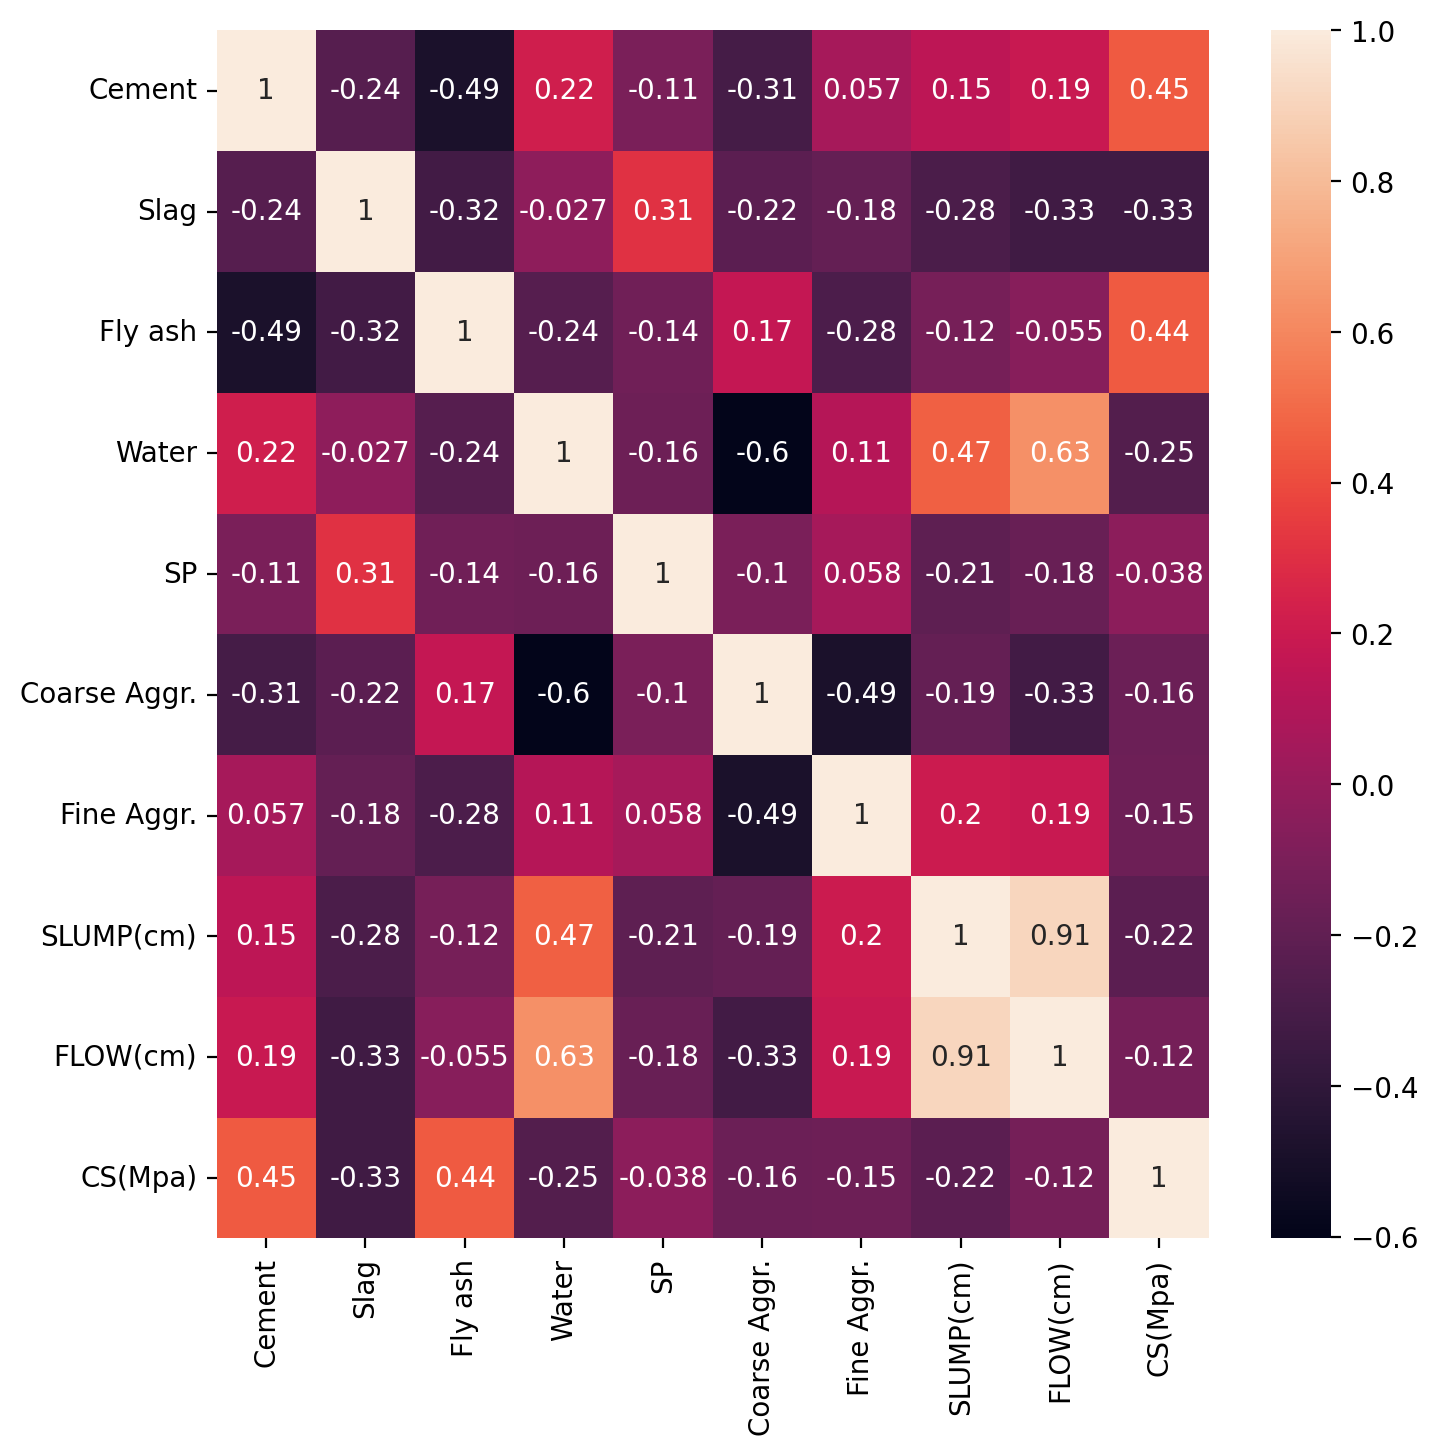

In [95]:
plt.figure(figsize=(8,8),dpi=200)
sns.heatmap(df.corr('pearson'),annot=True)
#newspaper kemungkinan drop

In [35]:
X = df.drop(['CS(Mpa)'],axis=1)
y = df['CS(Mpa)']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=101)

In [36]:
X_train,y_train=cek_outlier(X_train,y_train)


 Cement
Outliers: []
Outliers: []
Tidak ada data yang sama.

 Slag
Outliers: []
Outliers: []
Tidak ada data yang sama.

 Fly ash
Outliers: []
Outliers: []
Tidak ada data yang sama.

 Water
Outliers: []
Outliers: []
Tidak ada data yang sama.

 SP
Outliers: [19.0]
Outliers: [19.0]
Data yang sama: {19.0}

 Coarse Aggr.
Outliers: []
Outliers: []
Tidak ada data yang sama.

 Fine Aggr.
Outliers: []
Outliers: []
Tidak ada data yang sama.

 SLUMP(cm)
Outliers: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Outliers: []
Tidak ada data yang sama.

 FLOW(cm)
Outliers: []
Outliers: []
Tidak ada data yang sama.


In [37]:
df_num_all=df.select_dtypes(exclude='O')

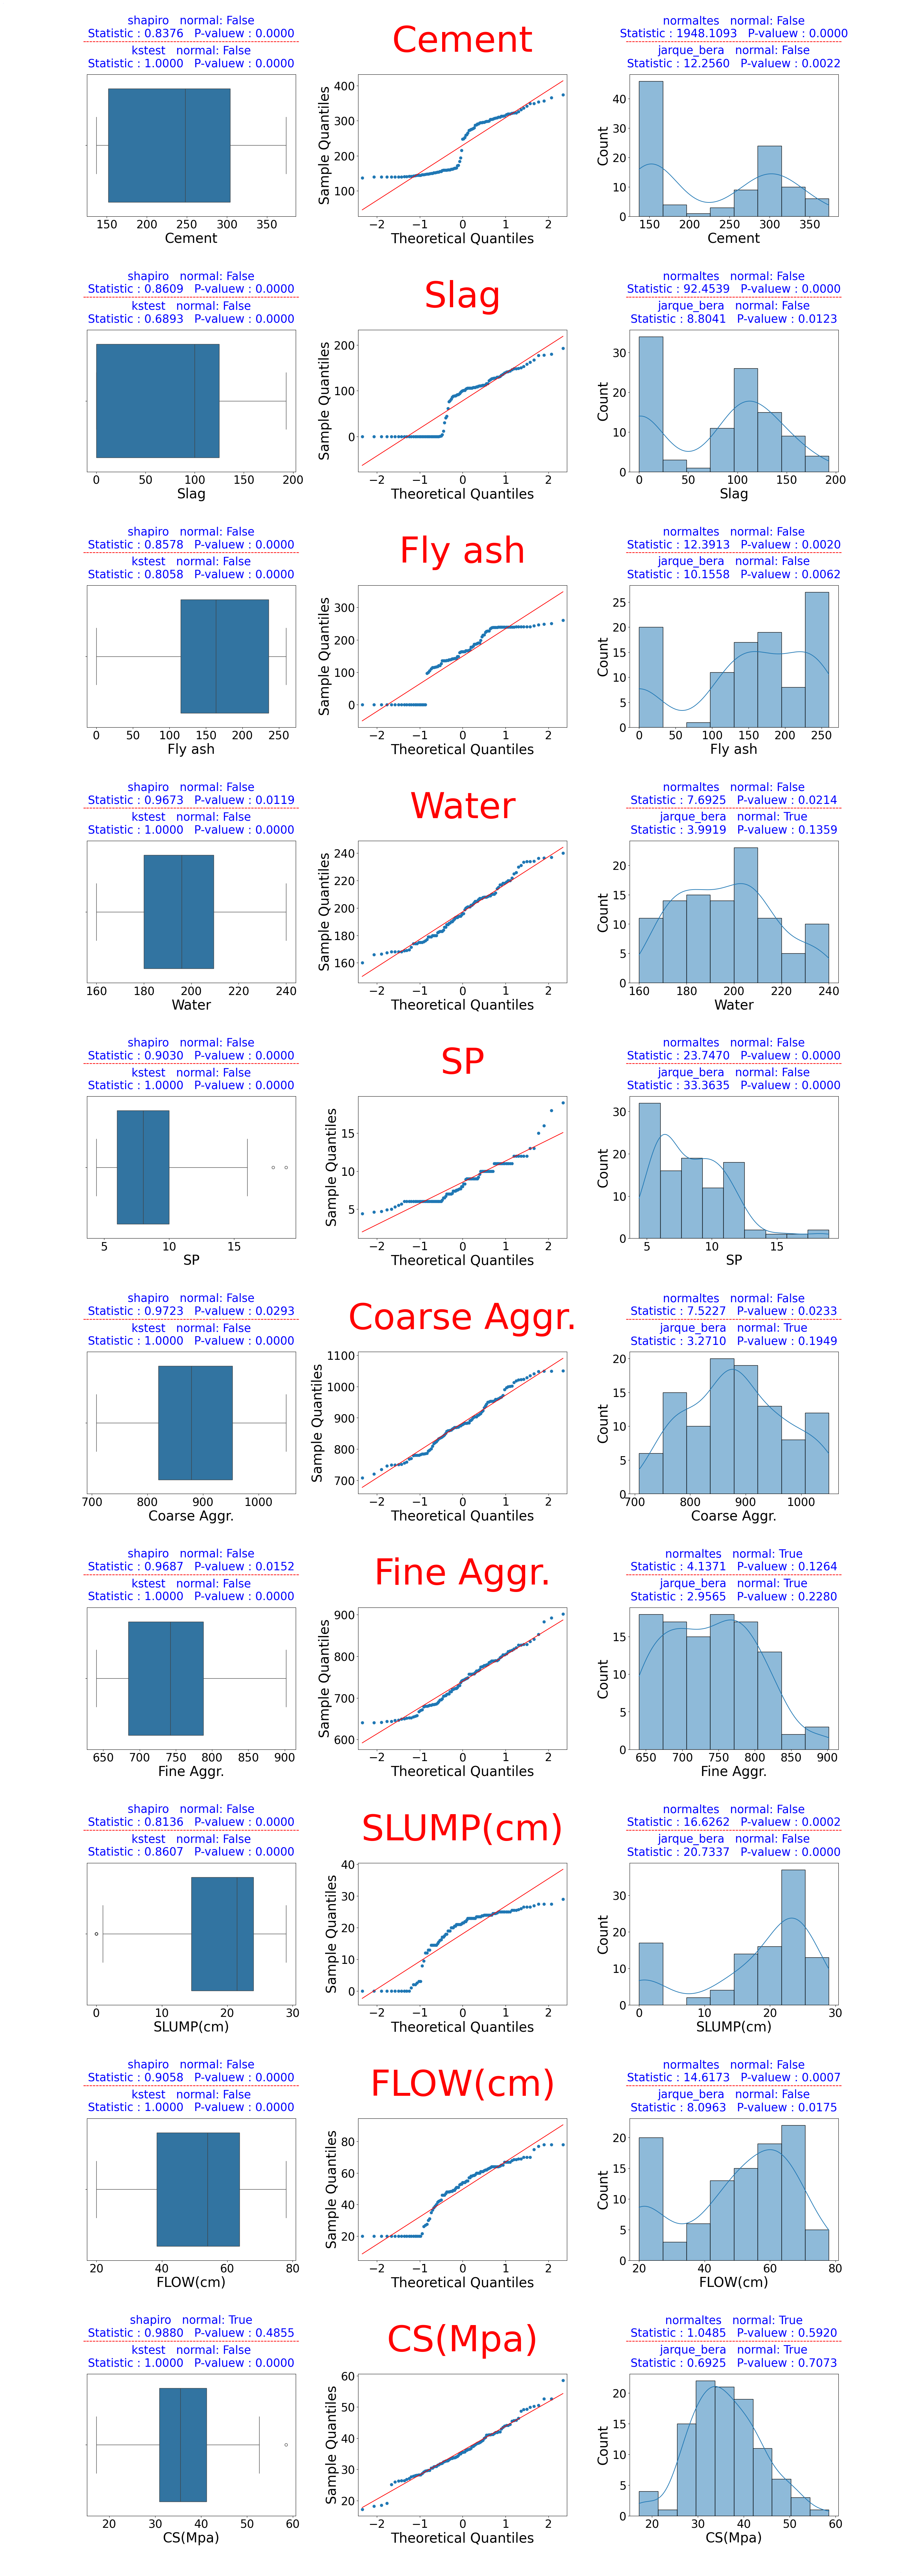

In [53]:
hh, fig, axes,df_count,yang_dipakai=visual_norm(df_num_all,True,0.05,100)


In [54]:
df_count

Columns Shapiro Normaltes Kstest Jarque_bera  banyak
0        Cement   False     False  False       False       0
1          Slag   False     False  False       False       0
2       Fly ash   False     False  False       False       0
3         Water   False     False  False        True       1
4            SP   False     False  False       False       0
5  Coarse Aggr.   False     False  False        True       1
6    Fine Aggr.   False      True  False        True       2
7     SLUMP(cm)   False     False  False       False       0
8      FLOW(cm)   False     False  False       False       0
9       CS(Mpa)    True      True  False        True       3

In [55]:
hh

Columns Shapiro Stat_shapiro P_value_shapiro Normaltes Stat_Normaltes  \
0        Cement   False       0.8376          0.0000     False      1948.1093   
1          Slag   False       0.8609          0.0000     False        92.4539   
2       Fly ash   False       0.8578          0.0000     False        12.3913   
3         Water   False       0.9673          0.0119     False         7.6925   
4            SP   False       0.9030          0.0000     False        23.7470   
5  Coarse Aggr.   False       0.9723          0.0293     False         7.5227   
6    Fine Aggr.   False       0.9687          0.0152      True         4.1371   
7     SLUMP(cm)   False       0.8136          0.0000     False        16.6262   
8      FLOW(cm)   False       0.9058          0.0000     False        14.6173   
9       CS(Mpa)    True       0.9880          0.4855      True         1.0485   

  P_value_Normaltes Kstest Stat_Kstest P_value_Kstest Jarque_bera  \
0            0.0000  False      1.0000         0.0000       False   
1            0.0000  False      0.6893         0.0000       False   
2            0.0020  False      0.8058         0.0000       False   
3            0.0214  False      1.0000         0.0000        True   
4            0.0000  False      1.0000         0.0000       False   
5            0.0233  False      1.0000         0.0000        True   
6            0.1264  False      1.0000         0.0000        True   
7            0.0002  False      0.8607         0.0000       False   
8            0.0007  False      1.0000         0.0000       False   
9            0.5920  False      1.0000         0.0000        True   

  Stat_Jarque_bera P_value_Jarque_bera  
0          12.2560              0.0022  
1           8.8041              0.0123  
2          10.1558              0.0062  
3           3.9919              0.1359  
4          33.3635              0.0000  
5           3.2710              0.1949  
6           2.9565              0.2280  
7          20.7337              0.0000  
8           8.0963              0.0175  
9           0.6925              0.7073

In [39]:
fig.savefig('100.png', bbox_inches='tight', facecolor='white')

In [57]:
yang_dipakai

6    Fine Aggr.
9       CS(Mpa)
Name: Columns, dtype: object

In [92]:

cek_variance(X_train,0.9)

9 9
Items in array1 but not in array2: []
Items in array2 but not in array1: []


In [93]:
from sklearn.feature_selection import mutual_info_regression
# determine the mutual information
mutual_info = mutual_info_regression(X_train.fillna(0), y_train)
mutual_info

mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)

#Coarse Aggr.  drop

Cement          0.436424
Fly ash         0.287925
Slag            0.247891
SLUMP(cm)       0.190080
FLOW(cm)        0.184034
Water           0.157353
SP              0.130665
Fine Aggr.      0.063147
Coarse Aggr.    0.000000
dtype: float64

In [97]:
ketemu=cari_cor_tabrak(X_train,y_train,0.85)
ketemu

Cement          0.435676
Slag            0.247796
Fly ash         0.286650
Water           0.157652
SP              0.129912
Coarse Aggr.    0.000000
Fine Aggr.      0.063403
SLUMP(cm)       0.193644
FLOW(cm)        0.180952
dtype: float64


corelasi ant    adalah    kolom1  variansi1    cor1 y     kolom2  \
0  FLOW(cm) <-> Slag  0.905902  FLOW(cm)  286.14997 -0.179226  SLUMP(cm)   

   variansi2  cor2 y  
0  71.962912 -0.2444

<Axes: >

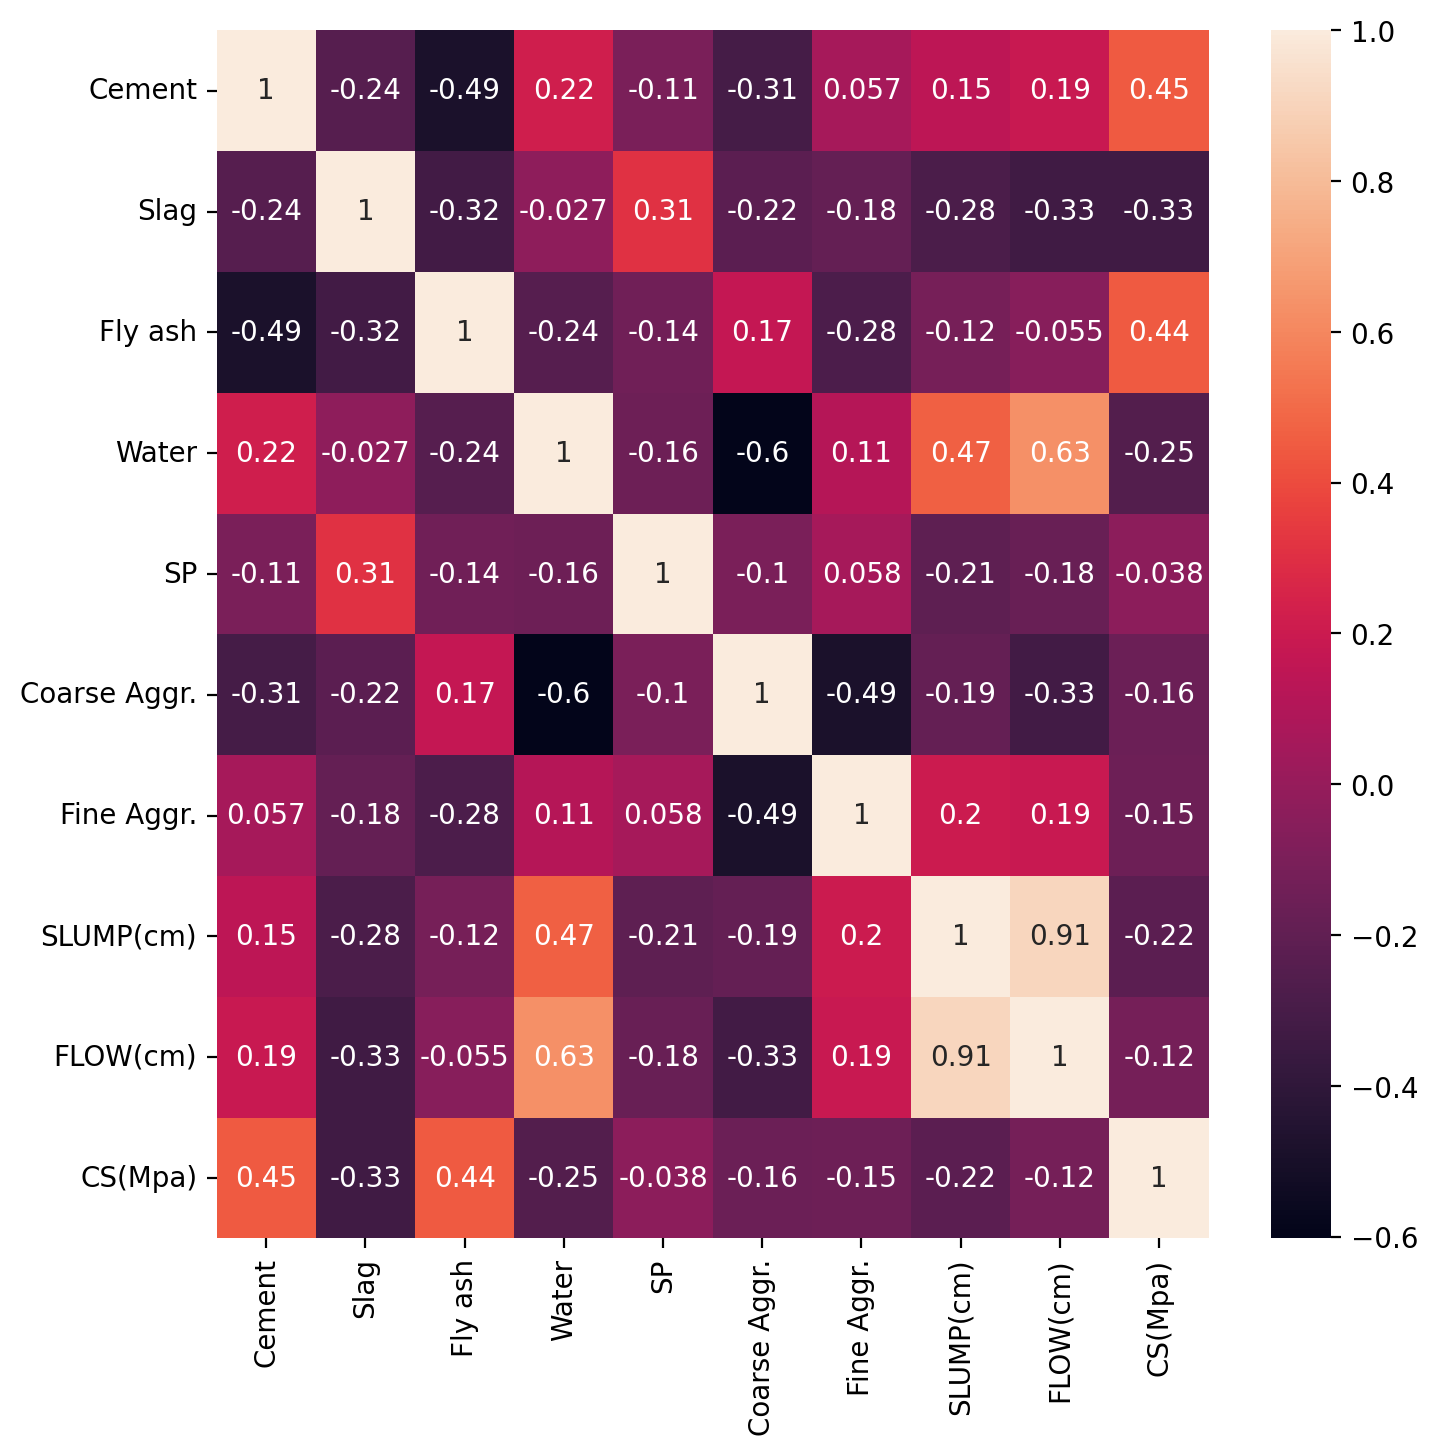

In [96]:
plt.figure(figsize=(8,8),dpi=200)
sns.heatmap(df.corr('pearson'),annot=True)
# FLOW(cm) kemungkinan drop

In [214]:
X = df.drop(['CS(Mpa)','Coarse Aggr.','FLOW(cm)'],axis=1)
y = df['CS(Mpa)']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=101)

In [215]:
X_train

Cement   Slag  Fly ash  Water    SP  Fine Aggr.  SLUMP(cm)
71   313.0  112.0      0.0  220.0  10.0       789.0      23.00
43   291.0  105.0      0.0  205.0   6.0       797.0      24.00
16   153.0    0.0    239.0  200.0   6.0       684.0      12.00
50   320.0    0.0    163.0  188.0   9.0       776.0      23.50
31   349.0    0.0    178.0  230.0   6.0       721.0      20.00
..     ...    ...      ...    ...   ...         ...        ...
63   291.0  104.0      0.0  231.0   9.0       725.0      23.00
70   276.0   90.0    116.0  180.0   9.0       768.0       0.00
81   140.1   11.8    226.1  207.8   4.9       683.8      21.00
11   148.0  109.0    139.0  193.0   7.0       902.0      23.75
95   184.3  153.4    239.2  179.0   7.5       640.9       0.00

[92 rows x 7 columns]

In [100]:
from sklearn import set_config
set_config(display='diagram')

In [101]:
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

svmr = SVR()
scatler=StandardScaler()

opera1=[('StandardScaler',scatler),('SVR',svmr)]
pipeline1=Pipeline(opera1)
pipeline1

Pipeline(steps=[('StandardScaler', StandardScaler()), ('SVR', SVR())])

In [126]:
kelip=[0.001,0.01,0.1,1,10]

param_grid = {
    'SVR__kernel': ['linear', 'rbf'],        # Derajat polinomial yang akan dicoba
    
    'SVR__gamma':['scale', 'auto'],
    'SVR__C':kelip,
    'SVR__epsilon':kelip
}

In [127]:
param_grid

{'SVR__kernel': ['linear', 'rbf'],
 'SVR__gamma': ['scale', 'auto'],
 'SVR__C': [0.001, 0.01, 0.1, 1, 10],
 'SVR__epsilon': [0.001, 0.01, 0.1, 1, 10]}

In [128]:


from sklearn.model_selection import GridSearchCV
# Inisialisasi GridSearchCV


# Inisialisasi GridSearchCV dengan menggunakan MAE sebagai skor evaluasi
grid_search = GridSearchCV(pipeline1, param_grid, cv=5,  scoring='neg_mean_squared_error')

# Lakukan pencarian grid
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('StandardScaler', StandardScaler()),
                                       ('SVR', SVR())]),
             param_grid={'SVR__C': [0.001, 0.01, 0.1, 1, 10],
                         'SVR__epsilon': [0.001, 0.01, 0.1, 1, 10],
                         'SVR__gamma': ['scale', 'auto'],
                         'SVR__kernel': ['linear', 'rbf']},
             scoring='neg_mean_squared_error')

In [129]:
pd.DataFrame(grid_search.cv_results_).sort_values(['mean_test_score'],ascending=False).head(10)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_SVR__C  \
88       0.012950      0.004992         0.003438        0.001385           10   
90       0.013868      0.004280         0.003238        0.000184           10   
94       0.009387      0.002684         0.002556        0.000541           10   
92       0.012642      0.004495         0.003262        0.000682           10   
86       0.009846      0.001411         0.003414        0.001343           10   
84       0.008936      0.001110         0.002594        0.000715           10   
80       0.008080      0.000690         0.002546        0.000449           10   
82       0.008117      0.000830         0.002412        0.000500           10   
72       0.006337      0.000934         0.002411        0.000503            1   
74       0.005801      0.000746         0.002329        0.000420            1   

   param_SVR__epsilon param_SVR__gamma param_SVR__kernel  \
88                0.1            scale            linear   
90                0.1             auto            linear   
94                  1             auto            linear   
92                  1            scale            linear   
86               0.01             auto            linear   
84               0.01            scale            linear   
80              0.001            scale            linear   
82              0.001             auto            linear   
72                  1            scale            linear   
74                  1             auto            linear   

                                               params  split0_test_score  \
88  {'SVR__C': 10, 'SVR__epsilon': 0.1, 'SVR__gamm...         -14.162272   
90  {'SVR__C': 10, 'SVR__epsilon': 0.1, 'SVR__gamm...         -14.162272   
94  {'SVR__C': 10, 'SVR__epsilon': 1, 'SVR__gamma'...         -14.947307   
92  {'SVR__C': 10, 'SVR__epsilon': 1, 'SVR__gamma'...         -14.947307   
86  {'SVR__C': 10, 'SVR__epsilon': 0.01, 'SVR__gam...         -14.648107   
84  {'SVR__C': 10, 'SVR__epsilon': 0.01, 'SVR__gam...         -14.648107   
80  {'SVR__C': 10, 'SVR__epsilon': 0.001, 'SVR__ga...         -14.847165   
82  {'SVR__C': 10, 'SVR__epsilon': 0.001, 'SVR__ga...         -14.847165   
72  {'SVR__C': 1, 'SVR__epsilon': 1, 'SVR__gamma':...         -17.216588   
74  {'SVR__C': 1, 'SVR__epsilon': 1, 'SVR__gamma':...         -17.216588   

    split1_test_score  split2_test_score  split3_test_score  \
88          -4.722436          -7.938489         -12.396649   
90          -4.722436          -7.938489         -12.396649   
94          -4.150187          -7.572926         -13.119358   
92          -4.150187          -7.572926         -13.119358   
86          -4.687989          -7.729974         -12.525441   
84          -4.687989          -7.729974         -12.525441   
80          -4.681064          -7.719269         -12.579920   
82          -4.681064          -7.719269         -12.579920   
72          -6.546266          -7.238265         -10.616983   
74          -6.546266          -7.238265         -10.616983   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  
88          -6.203837        -9.084736        3.616442                1  
90          -6.203837        -9.084736        3.616442                1  
94          -5.825332        -9.123022        4.192842                3  
92          -5.825332        -9.123022        4.192842                3  
86          -6.116748        -9.141652        3.814422                5  
84          -6.116748        -9.141652        3.814422                5  
80          -6.115961        -9.188676        3.884285                7  
82          -6.115961        -9.188676        3.884285                7  
72          -6.293973        -9.582415        4.120146                9  
74          -6.293973        -9.582415        4.120146                9

In [130]:
inis=ambil_best(grid_search,10)
inis

array([{'SVR__C': [10], 'SVR__epsilon': [0.1], 'SVR__gamma': ['auto'], 'SVR__kernel': ['linear']},
       {'SVR__C': [10], 'SVR__epsilon': [0.1], 'SVR__gamma': ['scale'], 'SVR__kernel': ['linear']},
       {'SVR__C': [10], 'SVR__epsilon': [1], 'SVR__gamma': ['auto'], 'SVR__kernel': ['linear']},
       {'SVR__C': [10], 'SVR__epsilon': [1], 'SVR__gamma': ['scale'], 'SVR__kernel': ['linear']},
       {'SVR__C': [10], 'SVR__epsilon': [0.01], 'SVR__gamma': ['auto'], 'SVR__kernel': ['linear']},
       {'SVR__C': [10], 'SVR__epsilon': [0.01], 'SVR__gamma': ['scale'], 'SVR__kernel': ['linear']},
       {'SVR__C': [10], 'SVR__epsilon': [0.001], 'SVR__gamma': ['scale'], 'SVR__kernel': ['linear']},
       {'SVR__C': [10], 'SVR__epsilon': [0.001], 'SVR__gamma': ['auto'], 'SVR__kernel': ['linear']},
       {'SVR__C': [1], 'SVR__epsilon': [1], 'SVR__gamma': ['auto'], 'SVR__kernel': ['linear']},
       {'SVR__C': [1], 'SVR__epsilon': [1], 'SVR__gamma': ['scale'], 'SVR__kernel': ['linear']}],
      dt

In [114]:
if __name__ == "__main__":

    experiment_id = mlflow.create_experiment(
        name="project_SVR_docker",
        tags={"env": "dev", "version": "1.0.0"},
    )

    print(experiment_id)
    


110493876254610796


In [131]:
run_name = "log___"
increment_number = 1

In [132]:
increment_number=input_mlflow(inis,increment_number,X_train, y_train,pipeline1,run_name,experiment_id)

run_id: f1bccc9205f94668a8500838c8ff0001
run_id: 0145d111442b4a54994cd6893ac317dc
run_id: 5a2332a4baac455b93423627daa65f71
run_id: 1a3c66ba42d044969d209aa4b417d872
run_id: 174539f8804e4cfbbbaed1b06e54ad7d
run_id: 616d4b140bfe43caab0089bc833b5f3e
run_id: e65ce2cc1a5149d4a48742f874c4a9cc
run_id: 0b5b622c34564be6bbfb49ef12cc9a45
run_id: bd68bbcbeb2a4aa59b155c6edf103650
run_id: 52b7b2053cfa42a49a98e9a095a45ce0
selesai


In [133]:
param_grid2 = {
    'SVR__kernel': ['sigmoid'],        # Derajat polinomial yang akan dicoba
    
    'SVR__gamma':['scale', 'auto'],
    'SVR__C':kelip,
    'SVR__epsilon':kelip,
    'SVR__coef0':kelip
}

In [134]:


from sklearn.model_selection import GridSearchCV
# Inisialisasi GridSearchCV


# Inisialisasi GridSearchCV dengan menggunakan MAE sebagai skor evaluasi
grid_search = GridSearchCV(pipeline1, param_grid2, cv=5,  scoring='neg_mean_squared_error')

# Lakukan pencarian grid
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('StandardScaler', StandardScaler()),
                                       ('SVR', SVR())]),
             param_grid={'SVR__C': [0.001, 0.01, 0.1, 1, 10],
                         'SVR__coef0': [0.001, 0.01, 0.1, 1, 10],
                         'SVR__epsilon': [0.001, 0.01, 0.1, 1, 10],
                         'SVR__gamma': ['scale', 'auto'],
                         'SVR__kernel': ['sigmoid']},
             scoring='neg_mean_squared_error')

In [135]:
pd.DataFrame(grid_search.cv_results_).sort_values(['mean_test_score'],ascending=False).head(10)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
151       0.006345      0.001829         0.003286        0.002805   
150       0.006885      0.001258         0.003760        0.000694   
153       0.007184      0.002735         0.001354        0.001658   
152       0.006330      0.002847         0.002215        0.002507   
155       0.007670      0.001115         0.004006        0.001193   
154       0.010204      0.003520         0.004244        0.002186   
160       0.003021      0.002443         0.000557        0.001114   
161       0.001345      0.001037         0.003822        0.003435   
163       0.003912      0.003627         0.001302        0.002603   
162       0.007594      0.001665         0.000720        0.001441   

    param_SVR__C param_SVR__coef0 param_SVR__epsilon param_SVR__gamma  \
151            1            0.001              0.001             auto   
150            1            0.001              0.001            scale   
153            1            0.001               0.01             auto   
152            1            0.001               0.01            scale   
155            1            0.001                0.1             auto   
154            1            0.001                0.1            scale   
160            1             0.01              0.001            scale   
161            1             0.01              0.001             auto   
163            1             0.01               0.01             auto   
162            1             0.01               0.01            scale   

    param_SVR__kernel                                             params  \
151           sigmoid  {'SVR__C': 1, 'SVR__coef0': 0.001, 'SVR__epsil...   
150           sigmoid  {'SVR__C': 1, 'SVR__coef0': 0.001, 'SVR__epsil...   
153           sigmoid  {'SVR__C': 1, 'SVR__coef0': 0.001, 'SVR__epsil...   
152           sigmoid  {'SVR__C': 1, 'SVR__coef0': 0.001, 'SVR__epsil...   
155           sigmoid  {'SVR__C': 1, 'SVR__coef0': 0.001, 'SVR__epsil...   
154           sigmoid  {'SVR__C': 1, 'SVR__coef0': 0.001, 'SVR__epsil...   
160           sigmoid  {'SVR__C': 1, 'SVR__coef0': 0.01, 'SVR__epsilo...   
161           sigmoid  {'SVR__C': 1, 'SVR__coef0': 0.01, 'SVR__epsilo...   
163           sigmoid  {'SVR__C': 1, 'SVR__coef0': 0.01, 'SVR__epsilo...   
162           sigmoid  {'SVR__C': 1, 'SVR__coef0': 0.01, 'SVR__epsilo...   

     split0_test_score  split1_test_score  split2_test_score  \
151         -37.379006         -49.179702         -28.269530   
150         -37.379006         -49.179702         -28.269530   
153         -37.370526         -49.177261         -28.290571   
152         -37.370526         -49.177261         -28.290571   
155         -37.294636         -49.169435         -28.450912   
154         -37.294636         -49.169435         -28.450912   
160         -37.573538         -49.379096         -28.381324   
161         -37.573538         -49.379096         -28.381324   
163         -37.565176         -49.380802         -28.402491   
162         -37.565176         -49.380802         -28.402491   

     split3_test_score  split4_test_score  mean_test_score  std_test_score  \
151         -20.034822         -20.982152       -31.169042       10.946216   
150         -20.034822         -20.982152       -31.169042       10.946216   
153         -20.076196         -21.033854       -31.189682       10.925302   
152         -20.076196         -21.033854       -31.189682       10.925302   
155         -20.212417         -21.315654       -31.288611       10.825809   
154         -20.212417         -21.315654       -31.288611       10.825809   
160         -20.000025         -21.164493       -31.299696       11.001342   
161         -20.000025         -21.164493       -31.299696       11.001342   
163         -20.040426         -21.217503       -31.321280       10.981766   
162         -20.040426         -21.217503       -31.321280       10.981766   

     rank_test_score  
151              

In [136]:
inis2=ambil_best(grid_search,6)
inis2

array([{'SVR__C': [1], 'SVR__coef0': [0.001], 'SVR__epsilon': [0.001], 'SVR__gamma': ['scale'], 'SVR__kernel': ['sigmoid']},
       {'SVR__C': [1], 'SVR__coef0': [0.001], 'SVR__epsilon': [0.001], 'SVR__gamma': ['auto'], 'SVR__kernel': ['sigmoid']},
       {'SVR__C': [1], 'SVR__coef0': [0.001], 'SVR__epsilon': [0.01], 'SVR__gamma': ['scale'], 'SVR__kernel': ['sigmoid']},
       {'SVR__C': [1], 'SVR__coef0': [0.001], 'SVR__epsilon': [0.01], 'SVR__gamma': ['auto'], 'SVR__kernel': ['sigmoid']},
       {'SVR__C': [1], 'SVR__coef0': [0.001], 'SVR__epsilon': [0.1], 'SVR__gamma': ['scale'], 'SVR__kernel': ['sigmoid']},
       {'SVR__C': [1], 'SVR__coef0': [0.001], 'SVR__epsilon': [0.1], 'SVR__gamma': ['auto'], 'SVR__kernel': ['sigmoid']}],
      dtype=object)

In [137]:
increment_number=input_mlflow(inis2,increment_number,X_train, y_train,pipeline1,run_name,experiment_id)

run_id: b195479fd2dd492f9e4940ffc7028d29
run_id: e59e466a881947619a295c22e7bd6dc8
run_id: 8cae56b765ca4d078fe3354a80abb84a
run_id: cdb8895a43b04ed5818a57961504c69b
run_id: 20872c3e0ad64fa18a01009e29221423
run_id: da930d539e174752bee5d413e00322c9
selesai


In [138]:
param_grid3 = {
    'SVR__kernel': ['poly'],
    'SVR__degree': [2,3,4,5,6,7,8],# Derajat polinomial yang akan dicoba
    
    'SVR__gamma':['scale', 'auto'],
    'SVR__C':kelip,
    'SVR__epsilon':kelip,
    'SVR__coef0':kelip
}

In [139]:


from sklearn.model_selection import GridSearchCV
# Inisialisasi GridSearchCV


# Inisialisasi GridSearchCV dengan menggunakan MAE sebagai skor evaluasi
grid_search = GridSearchCV(pipeline1, param_grid3, cv=5,  scoring='neg_mean_squared_error')

# Lakukan pencarian grid
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('StandardScaler', StandardScaler()),
                                       ('SVR', SVR())]),
             param_grid={'SVR__C': [0.001, 0.01, 0.1, 1, 10],
                         'SVR__coef0': [0.001, 0.01, 0.1, 1, 10],
                         'SVR__degree': [2, 3, 4, 5, 6, 7, 8],
                         'SVR__epsilon': [0.001, 0.01, 0.1, 1, 10],
                         'SVR__gamma': ['scale', 'auto'],
                         'SVR__kernel': ['poly']},
             scoring='neg_mean_squared_error')

In [141]:
pd.DataFrame(grid_search.cv_results_).sort_values(['mean_test_score'],ascending=False).head(10)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
1341       0.087097      0.017685         0.003502        0.000545   
1340       0.084240      0.014813         0.002713        0.001892   
1342       0.085685      0.014076         0.004206        0.001284   
1343       0.086533      0.013135         0.003899        0.000272   
1345       0.049596      0.007889         0.002222        0.001929   
1344       0.055919      0.011087         0.003037        0.001562   
1685       0.098036      0.042152         0.005267        0.001943   
1684       0.085507      0.042363         0.003589        0.003482   
1705       0.122112      0.025293         0.003245        0.000669   
1704       0.125131      0.025532         0.003744        0.001108   

     param_SVR__C param_SVR__coef0 param_SVR__degree param_SVR__epsilon  \
1341            1               10                 3              0.001   
1340            1               10                 3              0.001   
1342            1               10                 3               0.01   
1343            1               10                 3               0.01   
1345            1               10                 3                0.1   
1344            1               10                 3                0.1   
1685           10               10                 2                0.1   
1684           10               10                 2                0.1   
1705           10               10                 4                0.1   
1704           10               10                 4                0.1   

     param_SVR__gamma param_SVR__kernel  \
1341             auto              poly   
1340            scale              poly   
1342            scale              poly   
1343             auto              poly   
1345             auto              poly   
1344            scale              poly   
1685             auto              poly   
1684            scale              poly   
1705             auto              poly   
1704            scale              poly   

                                                 params  split0_test_score  \
1341  {'SVR__C': 1, 'SVR__coef0': 10, 'SVR__degree':...          -1.170047   
1340  {'SVR__C': 1, 'SVR__coef0': 10, 'SVR__degree':...          -1.170047   
1342  {'SVR__C': 1, 'SVR__coef0': 10, 'SVR__degree':...          -1.158639   
1343  {'SVR__C': 1, 'SVR__coef0': 10, 'SVR__degree':...          -1.158639   
1345  {'SVR__C': 1, 'SVR__coef0': 10, 'SVR__degree':...          -1.130089   
1344  {'SVR__C': 1, 'SVR__coef0': 10, 'SVR__degree':...          -1.130089   
1685  {'SVR__C': 10, 'SVR__coef0': 10, 'SVR__degree'...          -1.013490   
1684  {'SVR__C': 10, 'SVR__coef0': 10, 'SVR__degree'...          -1.013490   
1705  {'SVR__C': 10, 'SVR__coef0': 10, 'SVR__degree'...          -0.857378   
1704  {'SVR__C': 10, 'SVR__coef0': 10, 'SVR__degree'...          -0.857378   

      split1_test_score  split2_test_score  split3_test_score  \
1341          -0.705244          -0.262159          -0.249773   
1340          -0.705244          -0.262159          -0.249773   
1342          -0.720605          -0.263561          -0.249190   
1343          -0.720605          -0.263561          -0.249190   
1345          -0.974058          -0.263880          -0.269486   
1344          -0.974058          -0.263880          -0.269486   
1685          -0.876693          -0.591512          -0.401839   
1684          -0.876693          -0.591512          -0.401839   
1705          -1.085833          -0.984280          -0.286468   
1704          -1.085833          -0.984280          -0.286468   

      split4_test_score  mean_test_score  std_test_score  rank_test_score  
1341          -0.511970        -0.579839        0.340160                1  
1340          -0.511970        -0.579839        0.340160                1  
1342          -0.512329        -0.580865        0.337265                3  
1343          -0.512329        -0.580865        0.337265

In [142]:
inis2=ambil_best(grid_search,10)
inis2

array([{'SVR__C': [1], 'SVR__coef0': [10], 'SVR__degree': [3], 'SVR__epsilon': [0.001], 'SVR__gamma': ['scale'], 'SVR__kernel': ['poly']},
       {'SVR__C': [1], 'SVR__coef0': [10], 'SVR__degree': [3], 'SVR__epsilon': [0.001], 'SVR__gamma': ['auto'], 'SVR__kernel': ['poly']},
       {'SVR__C': [1], 'SVR__coef0': [10], 'SVR__degree': [3], 'SVR__epsilon': [0.01], 'SVR__gamma': ['scale'], 'SVR__kernel': ['poly']},
       {'SVR__C': [1], 'SVR__coef0': [10], 'SVR__degree': [3], 'SVR__epsilon': [0.01], 'SVR__gamma': ['auto'], 'SVR__kernel': ['poly']},
       {'SVR__C': [1], 'SVR__coef0': [10], 'SVR__degree': [3], 'SVR__epsilon': [0.1], 'SVR__gamma': ['scale'], 'SVR__kernel': ['poly']},
       {'SVR__C': [1], 'SVR__coef0': [10], 'SVR__degree': [3], 'SVR__epsilon': [0.1], 'SVR__gamma': ['auto'], 'SVR__kernel': ['poly']},
       {'SVR__C': [10], 'SVR__coef0': [10], 'SVR__degree': [2], 'SVR__epsilon': [0.1], 'SVR__gamma': ['scale'], 'SVR__kernel': ['poly']},
       {'SVR__C': [10], 'SVR__coef0':

In [143]:
increment_number=input_mlflow(inis2,increment_number,X_train, y_train,pipeline1,run_name,experiment_id)

run_id: e92b142aa3ec42199e561fc66f463119
run_id: 5566cdc7e4d848f994acaeb4aab1dc62
run_id: 79857f1dd18f45b9b12d006ad3d0c18a
run_id: ca4a3fba96ed4a919b18d873916d0a91
run_id: 48a22657eea04464bef462e19825f814
run_id: 55fcc6d784204072aaa3ff6db1ecfa31
run_id: 402808e9aa2548608820a6384097a7b8
run_id: 4936310ccea34aeb9050978409a0d43d
run_id: de34bd4bea4241558f717778f0d92596
run_id: a7834096ba654f92adbfcf1625bc4bab
selesai


In [145]:
model20 = mlflow.sklearn.load_model('mlruns/110493876254610796/ca4a3fba96ed4a919b18d873916d0a91/artifacts/grid_search__20')
model18=mlflow.sklearn.load_model('mlruns/110493876254610796/5566cdc7e4d848f994acaeb4aab1dc62/artifacts/grid_search__18')
model22=mlflow.sklearn.load_model('mlruns/110493876254610796/55fcc6d784204072aaa3ff6db1ecfa31/artifacts/grid_search__22')




In [147]:
from sklearn.ensemble import VotingRegressor

voting_pipe = Pipeline([
    ('voting', VotingRegressor(estimators=[
        ('grid_search20', model20.best_estimator_),
        ('grid_search22', model22.best_estimator_),
         # Model terbaik dari grid search pertama
        ('grid_search18',model18.best_estimator_)   # Model terbaik dari grid search kedua
    ]))
])
voting_pipe.fit(X_train,y_train)


Pipeline(steps=[('voting',
                 VotingRegressor(estimators=[('grid_search20',
                                              Pipeline(steps=[('StandardScaler',
                                                               StandardScaler()),
                                                              ('SVR',
                                                               SVR(C=1,
                                                                   coef0=10,
                                                                   epsilon=0.01,
                                                                   gamma='auto',
                                                                   kernel='poly'))])),
                                             ('grid_search22',
                                              Pipeline(steps=[('StandardScaler',
                                                               StandardScaler()),
                                                              ('SVR',
                                                               SVR(C=1,
                                                                   coef0=10,
                                                                   gamma='auto',
                                                                   kernel='poly'))])),
                                             ('grid_search18',
                                              Pipeline(steps=[('StandardScaler',
                                                               StandardScaler()),
                                                              ('SVR',
                                                               SVR(C=1,
                                                                   coef0=10,
                                                                   epsilon=0.001,
                                                                   gamma='auto',
                                                                   kernel='poly'))]))]))])

In [153]:
mod18=model18.predict(X_test)
mod20=model20.predict(X_test)
mod22=model22.predict(X_test)
vote=voting_pipe.predict(X_test)


In [213]:
X_test

Cement   Slag  Fly ash  Water    SP  Fine Aggr.  SLUMP(cm)
37   165.0  150.0      0.0  182.0  12.0       729.0      14.50
1    163.0  149.0    191.0  180.0  12.0       746.0       0.00
69   336.0  134.0      0.0  222.0   6.0       787.0      26.00
80   140.1    4.2    215.9  193.9   4.7       710.1      24.50
92   303.8    0.2    239.8  236.4   8.3       715.3      25.00
61   288.0    0.0    121.0  177.0   7.0       829.0      22.50
85   140.5   61.1    238.9  182.5   5.7       681.4      24.50
53   309.0    0.0    142.0  218.0  10.0       680.0      24.00
88   150.4  110.9    239.7  168.1   6.5       667.2       9.50
32   366.0    0.0    187.0  191.0   7.0       757.0      24.75
6    152.0  139.0    178.0  168.0  18.0       695.0       0.00

In [154]:
y_test=y_test.reset_index(drop=True)

In [155]:
gabungan=pd.concat([y_test,pd.DataFrame(mod18),pd.DataFrame(mod20),pd.DataFrame(mod22),pd.DataFrame(vote)],axis=1)
gabungan.columns=(['Actual','Predicted 1','Predicted 3','Predicted 2','vote'])
gabungan=gabungan.sort_values(['Actual'])
gabungan=gabungan.reset_index(drop=True)
gabungan

Actual  Predicted 1  Predicted 3  Predicted 2       vote
0    18.26    17.925221    17.919133    17.970679  17.938344
1    26.42    26.880850    26.864749    26.829807  26.858468
2    30.97    30.590915    30.582398    30.665347  30.612887
3    31.90    31.767869    31.778114    31.837533  31.794505
4    37.92    37.173834    37.179338    37.210910  37.188027
5    38.59    38.203291    38.214072    38.255338  38.224234
6    38.86    39.358958    39.368546    39.436958  39.388154
7    39.93    39.875444    39.879949    39.964199  39.906531
8    41.14    40.540737    40.540265    40.546779  40.542594
9    44.48    44.577929    44.587002    44.667539  44.610823
10   52.65    52.773095    52.784303    52.784307  52.780569

In [219]:
gabungan.to_csv('hasil1.csv', index=False)

In [156]:



import plotly.graph_objs as go
x=gabungan.index.values
# Define traces for each line
trace_actual = go.Scatter(x=x, y=gabungan['Actual'].values, mode='lines', name='Actual',line=dict(color='red'))
trace_pred_1 = go.Scatter(x=x, y=gabungan['Predicted 1'].values, mode='lines', name='Predicted 1',line=dict(color='blue'))
trace_pred_2 = go.Scatter(x=x, y=gabungan['Predicted 2'].values, mode='lines', name='Predicted 2',line=dict(color='yellow'))
trace_pred_3 = go.Scatter(x=x, y=gabungan['Predicted 3'].values, mode='lines', name='Predicted 3',line=dict(color='green'))
trace_pred_v = go.Scatter(x=x, y=gabungan['vote'].values, mode='lines', name='Vote',line=dict(color='green'))

# Create the plotly figure
fig = go.Figure()

# Add traces to the figure
fig.add_trace(trace_actual)
fig.add_trace(trace_pred_1)
fig.add_trace(trace_pred_2)
fig.add_trace(trace_pred_3)
fig.add_trace(trace_pred_v)

# Update layout
fig.update_layout(
    title="Comparison of Actual and Predicted Values",
    xaxis_title="X Axis Title",
    yaxis_title="Y Axis Title",
    #xaxis_tickfont=dict(size=10)
)

# Show plot
fig.show()

In [158]:
import joblib

# Simpan pipeline ke dalam file menggunakan joblib
joblib.dump(voting_pipe, "voting_pipeline.joblib")
joblib.dump(model18, "model1.joblib")
joblib.dump(model20, "model2.joblib")
joblib.dump(model22, "model3.joblib")

['model3.joblib']

In [179]:
tambah=[]
for i in range(len(gabungan.columns[1:])):
    mae=mean_absolute_error(gabungan[gabungan.columns[0]], gabungan[gabungan.columns[1:][i]])
    mse=mean_squared_error(gabungan[gabungan.columns[0]], gabungan[gabungan.columns[1:][i]])
    rmse=np.sqrt(mse)
    r2=r2_score(gabungan[gabungan.columns[0]], gabungan[gabungan.columns[1:][i]])

    tambah.append([gabungan.columns[1:][i],mae,mse,rmse,r2])
    

In [186]:
final=pd.DataFrame(tambah)
final.columns=['','MAE','MSE','RMSE','R2']

In [187]:
final=final.set_index(final.columns[0])

In [211]:
final

MAE       MSE      RMSE        R2
                                                   
Predicted 1  0.346684  0.166157  0.407623  0.997864
Predicted 3  0.346485  0.165389  0.406680  0.997874
Predicted 2  0.330566  0.154758  0.393393  0.998011
vote         0.339172  0.161318  0.401644  0.997926

In [220]:
hh.to_csv('final1.csv', index=False)

In [210]:
df_final = df.drop(['Coarse Aggr.','FLOW(cm)'],axis=1)
df_final.to_csv('df_final.csv', index=False)

In [212]:
typee=[]
for i in range(len(df_final.columns)):
    #print(df_final.columns[i],df_final[df_final.columns[i]].dtypes)
    typee.append([df_final.columns[i],df_final[df_final.columns[i]].dtypes])
typeenya=pd.DataFrame(typee)
typeenya.columns=['Columns','Type']
typeenya

Columns     Type
0      Cement  float64
1        Slag  float64
2     Fly ash  float64
3       Water  float64
4          SP  float64
5  Fine Aggr.  float64
6   SLUMP(cm)  float64
7     CS(Mpa)  float64

In [205]:
typeenya.to_csv('typeenya.csv', index=False)

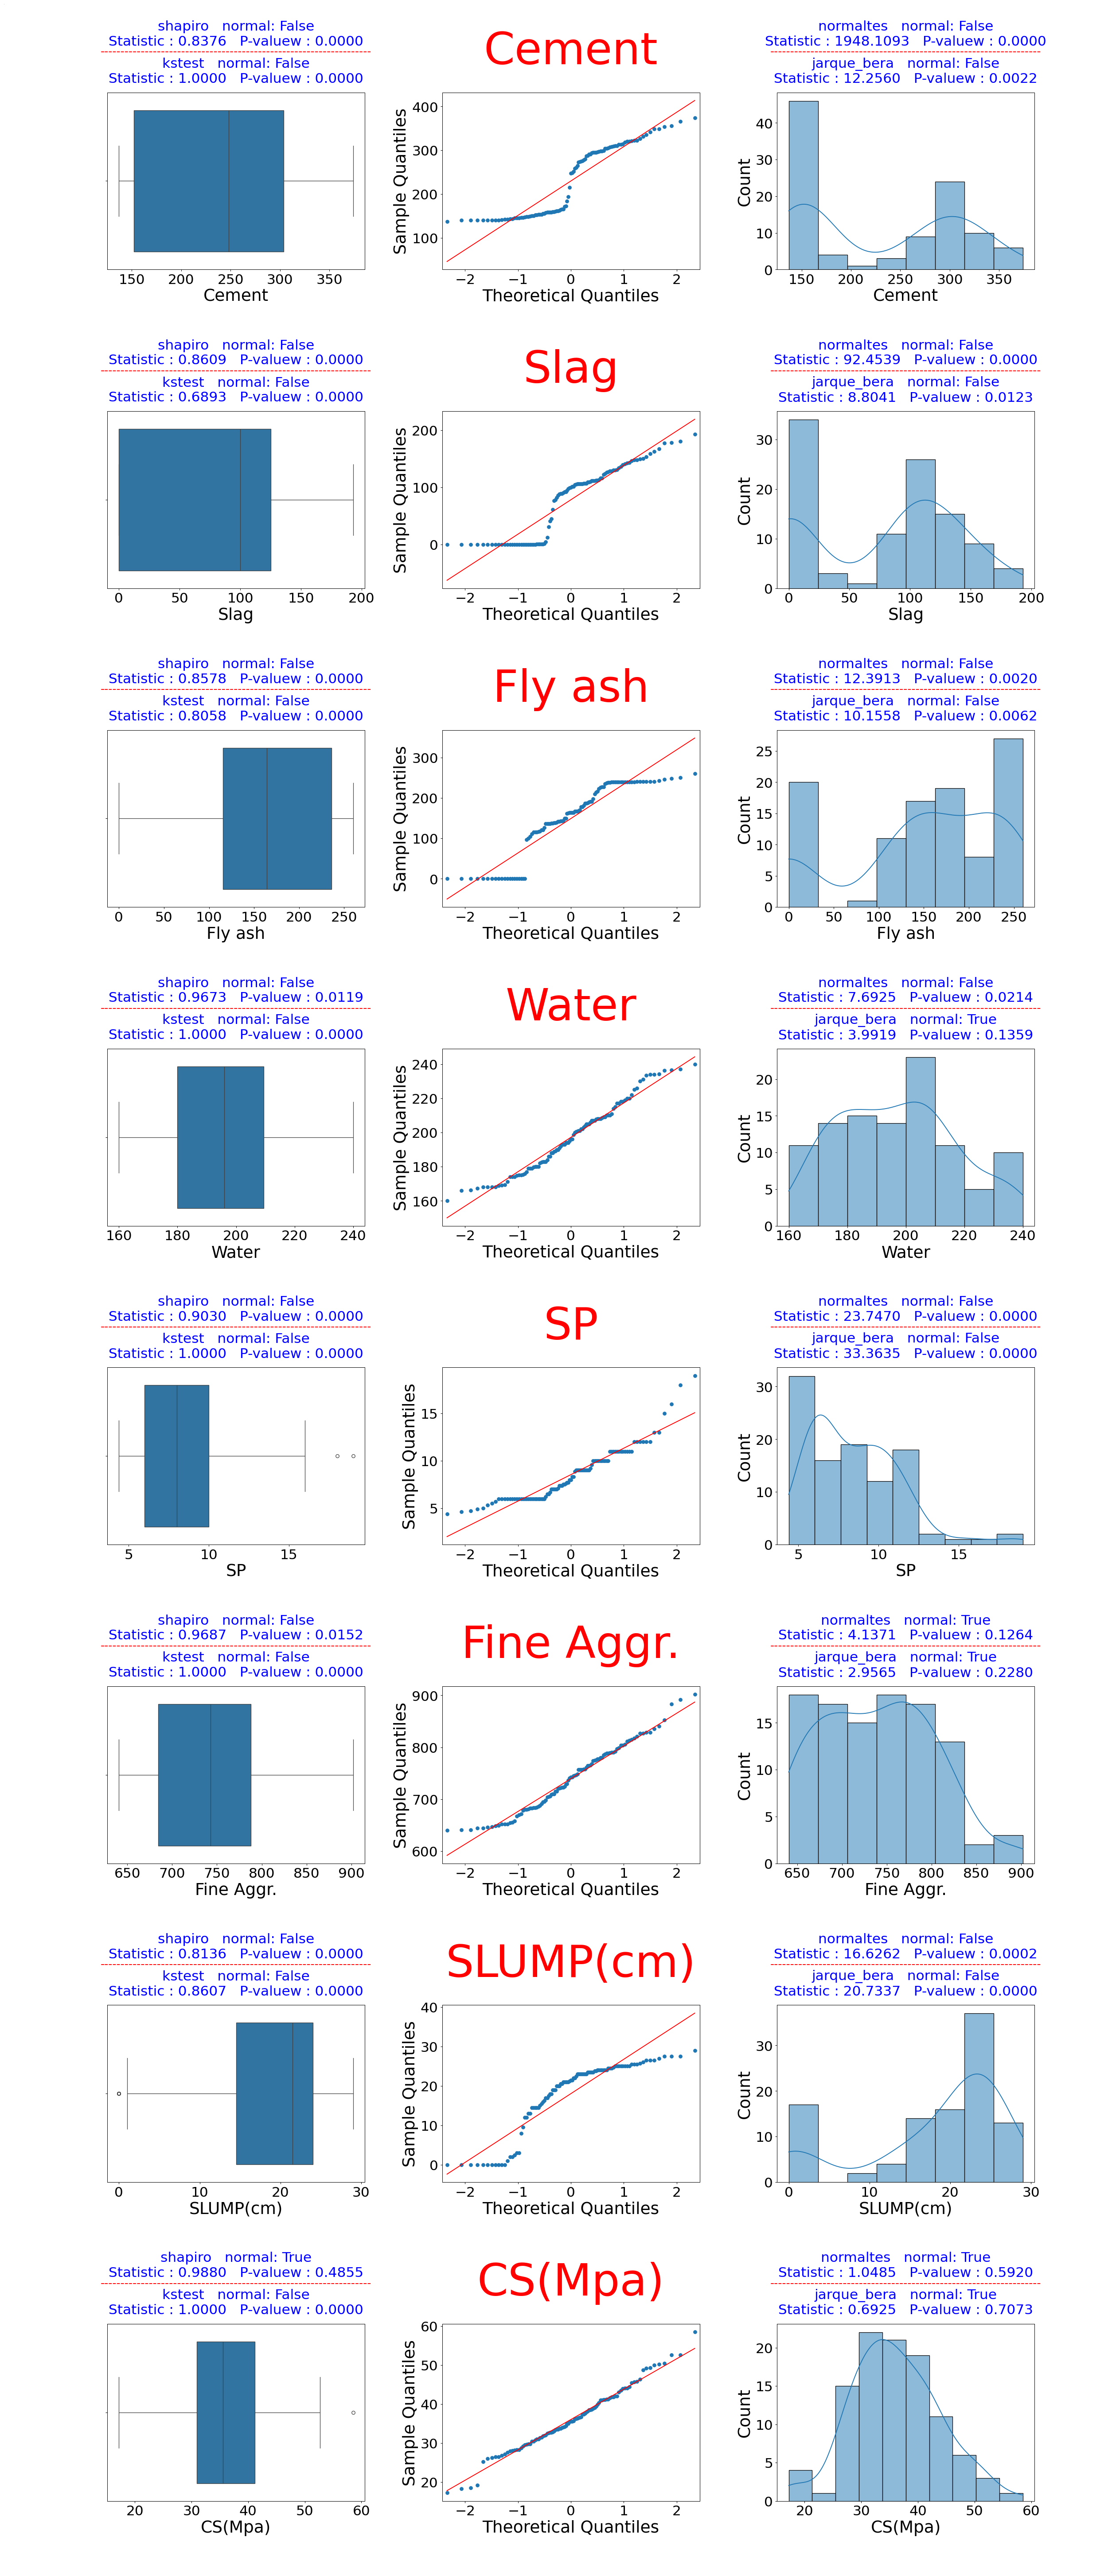

In [208]:
hh, fig, axes,df_count,yang_dipakai=visual_norm(df_final,True,0.05,90)


In [209]:
fig.savefig('90.png', bbox_inches='tight', facecolor='white')

In [218]:
gabungan

Actual  Predicted 1  Predicted 3  Predicted 2       vote
0    18.26    17.925221    17.919133    17.970679  17.938344
1    26.42    26.880850    26.864749    26.829807  26.858468
2    30.97    30.590915    30.582398    30.665347  30.612887
3    31.90    31.767869    31.778114    31.837533  31.794505
4    37.92    37.173834    37.179338    37.210910  37.188027
5    38.59    38.203291    38.214072    38.255338  38.224234
6    38.86    39.358958    39.368546    39.436958  39.388154
7    39.93    39.875444    39.879949    39.964199  39.906531
8    41.14    40.540737    40.540265    40.546779  40.542594
9    44.48    44.577929    44.587002    44.667539  44.610823
10   52.65    52.773095    52.784303    52.784307  52.780569